In [215]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from analysis.data import load_yaml
from analysis import plotting
import common

import seaborn.objects as so
import matplotlib as mpl
import pyarrow as pa

from analysis.fixation_filters import apply_fixation_filter
from analysis.configs import ivt_optimised_config
import fiddle as fdl
import dataclasses
from typing import Sequence
from minineedle import needle, core
from tqdm.auto import tqdm
import multiprocessing as mp
from toolz import itertoolz



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [216]:

    # return old_fixations.astype({"start_time": "datetime64[ms]"}), new_fixations.astype(
    #     {"start_time": "datetime64[ms]"}
    # ), fixed_fixations.astype({"start_time": "datetime64[ms]"})


In [217]:


def draw_fixation_regions_over_gazes(
        gazes,
        fixations,
        *,
        gaze_time='plugin_time',
        fixation_time='plugin_time',
        y='source_file_line',
        duration='duration',
        fig=None
):
    if fig is None:
        fig = mpl.figure.Figure(figsize=(20, 5), dpi=150)

    p = so.Plot(data=gazes, x=gaze_time, y=y).add(so.Dots(marker="x", color="black"))
    p = p.scale(
        x=so.Continuous().tick(every=30 * 1e3).label(like=plotting.time_formatter())
    )
    p.on(fig).plot()
    ax = fig.axes[0]
    plotting.mark_ranges(
        plotting.ranges_from_fixations(
            fixations[fixation_time], fixations[duration]
        ),
        ax=ax,
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
    )

    return p

In [223]:
key = ('p79', 't2')
old_fixations, new_fixations, fixed_fixations = common.load_fixation_data_for_diff()
# gazes = common.load_raw_gaze_data()

In [219]:
import intervaltree




In [225]:
keys = list(old_fixations.index.unique())
import itertools
tasks = list(itertoolz.partition_all(2, keys))

with mp.Pool(mp.cpu_count()) as pool:
    results = pool.imap_unordered(common.mp_worker_fixation_diff, tasks)
    results = itertools.chain(*tqdm(results, total=len(tasks)))
    results = list(results) 

100%|██████████| 152/152 [00:42<00:00,  3.58it/s]


In [226]:
df = pd.DataFrame(results).sort_values(by=['splits', 'sequence_diff'], ascending=False)

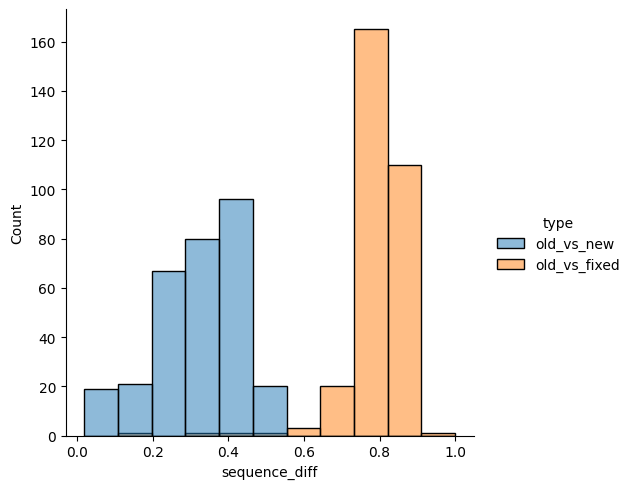

In [227]:
import seaborn as sns

sns.displot(
    data=df,
    x='sequence_diff',
    hue='type',
)

In [228]:
df.groupby('type').mean()

/var/folders/9t/pnh1mqks36vfw7ngs3d7n8r00000gn/T/ipykernel_62615/4010974869.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('type').mean()


,splits,missing,overlaps,sequence_diff
type,,,,
old_vs_fixed,0.010203,0.006084,0.983712,0.798116
old_vs_new,0.485226,0.074605,0.440169,0.323893


In [243]:
df.query('type == "old_vs_fixed"').sort_values(by="sequence_diff", ascending=True).to_csv('../data/interim/sequence_diffs_old_vs_new_fixations.csv', index=False)

In [241]:
fixed_fixations.loc[('p62', 't3')].astype({'start_time': 'datetime64[ms]'})

start_time  duration  source_file_line  source_file_col  \
pid tid                                                                        
p62 t3  2022-04-24 23:14:15.063     142.0                26               29   
    t3  2022-04-24 23:14:16.680      89.0                27               32   
    t3  2022-04-24 23:14:43.853     161.0                50               15   
    t3  2022-04-24 23:15:08.960     231.0                33               20   
    t3  2022-04-24 23:15:10.832     146.0                32               59   
    t3  2022-04-24 23:16:00.649     116.0                40                5   
    t3  2022-04-24 23:17:06.667     146.0                33               48   
    t3  2022-04-24 23:17:23.197      97.0                46               29   
    t3  2022-04-24 23:17:25.360      84.0                33               66   
    t3  2022-04-24 23:18:32.350      87.0                50               23   
    t3  2022-04-24 23:18:34.188      82.0                32               84   
    t3  2022-04-24 23:18:37.808     136.0                32               55   
    t3  2022-04-24 23:19:56.316     133.0                27               24   
    t3  2022-04-24 23:20:02.521     150.0                58               68   
    t3  2022-04-24 23:21:28.173      83.0                44               33   
    t3  2022-04-24 23:21:28.325     169.0                46               28   

          n  interpolated  position_interpolated  
pid tid                                           
p62 t3   17            16                      0  
    t3   11             8                      6  
    t3   21            18                     20  
    t3   29            27                      0  
    t3   20             7                     13  
    t3   15            11                      6  
    t3   16            15                      0  
    t3   11             6                      9  
    t3   10             6                      8  
    t3   12             8                      2  
    t3    9             7                      0  
    t3    7             6                      0  
    t3   15            10                     11  
    t3   19            17                      9  
    t3   10             8                      9  
    t3   16            14                      1

In [242]:
old_fixations.loc[('p62', 't3')].astype({'start_time': 'datetime64[ms]'})

start_time  duration  source_file_line  source_file_col  \
pid tid                                                                        
p62 t3  2022-04-24 23:14:15.134    1388.0              26.0             29.0   
    t3  2022-04-24 23:15:09.029     162.0              33.0             20.0   
    t3  2022-04-24 23:15:10.832      98.0              32.0             59.0   
    t3  2022-04-24 23:16:00.649     115.0              40.0             10.0   

            n  
pid tid        
p62 t3   31.0  
    t3   20.0  
    t3   22.0  
    t3    4.0